In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats,special

from calculator import *

rank_methods = RankMethods()

data = pd.read_csv('../data/res_evaluated.csv')
pd.set_option('display.max_columns',200)

3.1(Кореляційний аналіз):
Взяти дві змінні для дослідження кореляційної залежності.<br>
Для теста №1 за одну змінну взяти  дані деякої групи, в якості другої змінної взяти оцінки з математики <br>
Для теста №2 за одну змінну взяти бали мотивації для математичного предмета, в якості другої змінної бали мотивації цих же студентів для гуманітарного предмета.<br>
Для теста №3 за одну змінну взяти бали мотивації за шкалою “професійна діяльність”, в якості другої змінної бали мотивації цих же студентів для якоїсь іншої шкали.<br>

In [2]:
test_1 = {'x': data.loc[data['Курс']==4]['Улюблений предмет'].values, 'y':data.loc[data['Курс']==4]['Оцінка з цього предмету:'].values}
test_2 = {'x': data.loc[data['Курс']==4]['Test#2: Рівняння мат. фізики'].values, 'y':data.loc[data['Курс']==4]['Test#2: Технології прикладного програмування'].values}
test_3 = {'x': data[data['Курс']==4]['Професійні мотиви'].values, 'y': data[data['Курс']==4]['Мотиви творчої самореалізації'].values}

tests = [test_1,test_2,test_3]

*	Знайти вибіркові коефіцієнту кореляції Пірсона, Спірмена та Кенделла та перевірити їхню значущість за допомогою параметричного критерію Пірсона та непараметричних Спірмена та Кенделла.
*	Застосувати можливості Пайтона для знаходження коефіцієнту кореляції Пірсона, Спірмена та Кенделла і перевірки цих коефіцієнтів на значущість. 

Запрограмуємо тести:

In [3]:
def t_value(r,x):
    """
    t_value with n-2 ddof under the null hypothesis
    """
    n = x.shape[0]
    return r * np.sqrt(n-2) / np.sqrt(1-r**2)
def p_value_rho(r,x):
    """
    corresponding p_value
    """
    n = x.shape[0]
    t = t_value(r,x)
    return stats.t.sf(t,df=n-2)#1-t.cdf(t,n-2)

def pearson_correlation(x,y):
    """
    Pearson correlation coefficient r and p-value p for testing non-correlation
    """
    def cov(x,y):
        res = (x - mean(x))*(y-mean(y))
        return res.sum()/(x.shape[0]-1)
    
    def corr(x,y):
        return cov(x,y)/(stddev(x)*stddev(y))
    
    r = corr(x,y)
    p = 2*(p_value_rho(r,x))%1
    return r,p

def spearman_correlation(x,y):
    """
    Spearman correlation coefficient r and p-value p for testing non-correlation
    """
    def corr(x,y):
        rank_x,rank_y = rank_methods.rank(x), rank_methods.rank(y)
        if rank_methods.areDistinct(x,y):
            ranks_sum,n = rank_methods.rank_difference_sum(rank_x,rank_y),x.shape[0]
            return 1 - (6*ranks_sum)/(n**3-n)
        return pearson_correlation(rank_x,rank_y)[0]

    r = corr(x,y)
    p = (2*(p_value_rho(r,x)))%1
    
    
    return r,p

def kendall_correlation(x,y):
    """
    Kendall correlation coefficient r and p-value p for testing non-correlation
    """
    def corr(x,y):
        n = x.shape[0]
        c,d,t,u = concordant_discordant_ties(x,y)
        return (c-d)/np.sqrt((c+d+t)*(c+d+u))
    
    def p_val(x,y):
        c,d,_,_,n = *concordant_discordant_ties(x,y),x.size
        xtie, x0, x1 = count_rank_tie(x)     # ties in x, stats
        ytie, y0, y1 = count_rank_tie(y)     # ties in y, stats
        var = (n * (n - 1) * (2.*n + 5) - x1 - y1) / 18. + (
                2. * xtie * ytie) / (n * (n - 1)) + x0 * y0 / (9. *
                n * (n - 1) * (n - 2))
        
        return special.erfc(np.abs(c - d) / np.sqrt(var) / np.sqrt(2))
    
    r = corr(x,y)
    p = p_val(x,y)
    return r,p

Перевіримо коректність імплементацій на прикладі 1го тесту (порівняння оцінок з математики та улюбленого предмету):

In [4]:
p_res = pearson_correlation(test_1['x'],test_1['y'])
s_res = spearman_correlation(test_1['x'],test_1['y'])
k_res = kendall_correlation(test_1['x'],test_1['y'])

p_lib = stats.pearsonr(test_1['x'],test_1['y'])
s_lib = stats.spearmanr(test_1['x'],test_1['y'])
k_lib = stats.kendalltau(test_1['x'],test_1['y'])

print(f"My calculations:\nPearson`s r={p_res[0]:.4f}, p_value={p_res[1]:.4f}\nSpearman`s r={s_res[0]:.4f}, p_value={s_res[1]:.4f}\nKendall`s tau={k_res[0]:.4f} p_value={k_res[1]:.4f}\n")
print(f"Results from library:\nPearson`s r={p_lib[0]:.4f}, p_value={p_lib[1]:.4f}\nSpearman`s r={s_lib[0]:.4f}, p_value={s_lib[1]:.4f}\nKendall`s tau={k_lib[0]:.4f}, p_value={k_lib[1]:.4f}")


My calculations:
Pearson`s r=0.5115, p_value=0.0046
Spearman`s r=0.5413, p_value=0.0024
Kendall`s tau=0.4297 p_value=0.0030

Results from library:
Pearson`s r=0.5115, p_value=0.0046
Spearman`s r=0.5413, p_value=0.0024
Kendall`s tau=0.4297, p_value=0.0030


Одразу можемо зробити висновок по першому тесту: бачимо слабку лінійну залежність між оцінками з улюбленого предмету та математичної дисципліни. Розуміючи, що найбільш популярна оцінка з улюбленого предмету - 100, а з математики - 61, цілком погоджуємося з тестом<br><br><br>
Другий тест порівнює мотивацію студентів з рівнянь мат. фізики та технологій прикладного програмування

In [5]:
p_res = pearson_correlation(test_2['x'],test_2['y'])
s_res = spearman_correlation(test_2['x'],test_2['y'])
k_res = kendall_correlation(test_2['x'],test_2['y'])

p_lib = stats.pearsonr(test_2['x'],test_2['y'])
s_lib = stats.spearmanr(test_2['x'],test_2['y'])
k_lib = stats.kendalltau(test_2['x'],test_2['y'])

print(f"My calculations:\nPearson`s r={p_res[0]:.4f}, p_value={p_res[1]:.4f}\nSpearman`s r={s_res[0]:.4f}, p_value={s_res[1]:.4f}\nKendall`s tau={k_res[0]:.4f} p_value={k_res[1]:.4f}\n")
print(f"Results from library:\nPearson`s r={p_lib[0]:.4f}, p_value={p_lib[1]:.4f}\nSpearman`s r={s_lib[0]:.4f}, p_value={s_lib[1]:.4f}\nKendall`s tau={k_lib[0]:.4f}, p_value={k_lib[1]:.4f}")


My calculations:
Pearson`s r=0.4367, p_value=0.0179
Spearman`s r=0.3734, p_value=0.0460
Kendall`s tau=0.3099 p_value=0.0367

Results from library:
Pearson`s r=0.4367, p_value=0.0179
Spearman`s r=0.3734, p_value=0.0460
Kendall`s tau=0.3099, p_value=0.0367


Бачимо ще слабкішу додатню кореляцію, не маємо до цього жодних питань<br><br><br>
Третій тест буде порівнювати мотиваційні мотиви студентів: в нашому випадку, порівнюємо "професійні мотиви" та "мотиви творчої самореалізації"

In [6]:
p_res = pearson_correlation(test_3['x'],test_3['y'])
s_res = spearman_correlation(test_3['x'],test_3['y'])
#k_res = kendall_correlation(test_3['x'],test_3['y'])

p_lib = stats.pearsonr(test_3['x'],test_3['y'])
s_lib = stats.spearmanr(test_3['x'],test_3['y'])
#k_lib = stats.kendalltau(test_3['x'],test_3['y'])

print(f"My calculations:\nPearson`s r={p_res[0]:.4f}, p_value={1-p_res[1]:.4f}\nSpearman`s r={s_res[0]:.4f}, p_value={1-s_res[1]:.4f}\n")
print(f"Results from library:\nPearson`s r={p_lib[0]:.4f}, p_value={p_lib[1]:.4f}\nSpearman`s r={s_lib[0]:.4f}, p_value={s_lib[1]:.4f}\n")


My calculations:
Pearson`s r=-0.1346, p_value=0.4863
Spearman`s r=-0.0673, p_value=0.7287

Results from library:
Pearson`s r=-0.1346, p_value=0.4863
Spearman`s r=-0.0673, p_value=0.7287



Бачимо майже нульову кореляцію та досить значний p_value, що свідчить про близкість кореляції до нуля <br><br><br> Тепер перейдемо до лінійної регресії.

3.2(Регресійний аналіз):

*	Побудувати регресійну модель залежності однієї змінної  від іншої методом найменших квадратів та за умови відомого коефіцієнта кореляції Пірсона.
*	Побудувати регресійну модель в Пайтоні,  провести аналіз залишків різними методами. 

In [7]:
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error

class OLS(BaseEstimator):
    def __init__(self):
        super(OLS,self).__init__()
        
    def fit(self,X,y=None):
        self.r_,_ = pearson_correlation(X,y)
        
        self.beta_ = self.r_*stddev(y)/stddev(X)
        self.alpha_ = mean(y) - mean(X)*self.beta_
        return self
        
    def predict(self,X,y=None):
        try:
            getattr(self, "beta_")
            getattr(self, "alpha_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        
        return self.alpha_ + X*self.beta_
    
def predict(x,y):
    model = OLS().fit(x,y)
    pred = model.predict(x)
    return pred,model.beta_,model.alpha_

Побудуємо регресії залежностей однієї змінної від іншої для кожної пари змінних кожного тесту. Якість моделі оцінюємо середньоквадратичним відхиленням

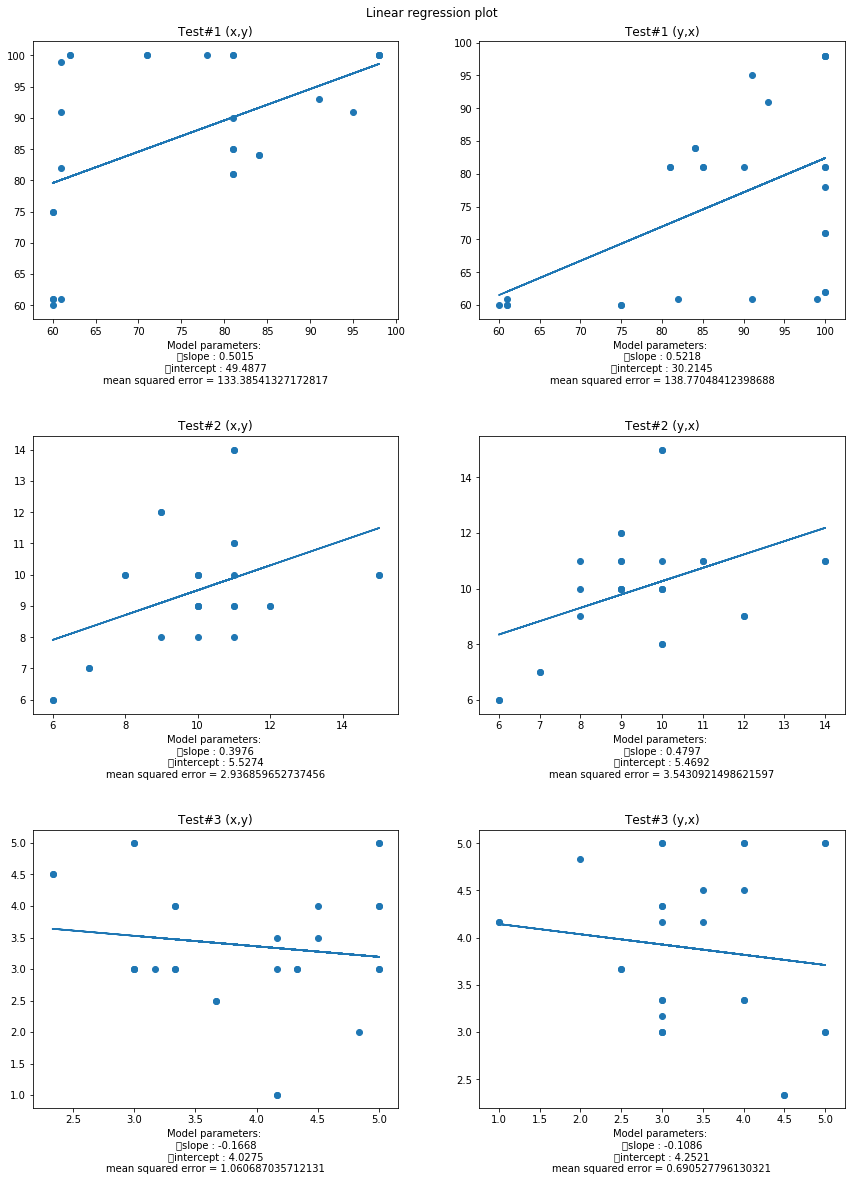

In [8]:
fig,ax = plt.subplots(3,2,figsize = (12,16))

fig.tight_layout(h_pad=10, w_pad=5)
fig.subplots_adjust(top=0.95)
fig.suptitle('Linear regression plot',fontsize=12)
fig.subplots_adjust(top=0.95)

for i in range(3):
    pred,beta1,alpha1 = predict(tests[i]['x'],tests[i]['y'])
    pred_reversed,beta2,alpha2 = predict(tests[i]['y'],tests[i]['x'])
    
    ax[i,0].plot(tests[i]['x'],pred)
    ax[i,0].scatter(tests[i]['x'],tests[i]['y'])
    ax[i,0].set_title(f"Test#{i+1} (x,y)")
    ax[i,0].set_xlabel(f"Model parameters: \n\tslope : {beta1:.4f}\n\tintercept : {alpha1:.4f}\nmean squared error = {mean_squared_error(tests[i]['y'],pred)}")
    
    ax[i,1].plot(tests[i]['y'],pred_reversed)
    ax[i,1].scatter(tests[i]['y'],tests[i]['x'])
    ax[i,1].set_title(f"Test#{i+1} (y,x)")
    ax[i,1].set_xlabel(f"Model parameters: \n\tslope : {beta2:.4f}\n\tintercept : {alpha2:.4f}\nmean squared error = {mean_squared_error(tests[i]['x'],pred_reversed)}")

Маємо занадто розріджені дані, аби лінійна регресія їх нормально апроксимувала.<br><br>

Отже, в ході роботи було проведено кореляційний та регресійний аналіз залежності між змінними деяких тестів. Лінійна кореляція для всіх трьох тестів слабка або майже відсутня, оцінка регресії методом найменших квадратів дає досить велике середньоквадратичне відхилення. Зауважимо, що тести були проведені на вибірці розміру 30, що все ж таки є недостатньою для повноцінного дослідження